In [8]:
# Basic imports and setup
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from analyze_modules import load_parameter_sweep
from analyze_modules.plot_utils import _get_scalar_data

# get viridis colormap
cmap = plt.get_cmap('viridis')
cmap.set_bad(color='black')
plt.rcParams['figure.dpi'] = 200

In [9]:
# habitability params
T_freeze = 273.15 # K
T_boil = np.array([100, 180, 310]) # deg C for P = [1, 10, 100] bar
T_boil = T_boil + T_freeze # K
P_boil = np.array([1, 10, 100]) # bar

In [10]:
# Parameters
P0s = np.array([1e6, 1e7, 1e8])
Tints = np.array([50, 75, 100, 125, 150, 200, 250])
CplusOs = np.array([1e-3, 1e-2, 1e-1])
CtoOs = np.array([0.1, 0.59, 1.0])
planets = np.array(['Earth', 'Io'])
adds = ['', '_aN=1e-4', '_aN=1e-2']
folder = '../output/EqCond+Remove/'

In [19]:
# Load the data by performing sweeps inside a loop

tsurfs = np.zeros((len(planets), len(P0s), len(Tints)))

for i_planet, planet_name in enumerate(planets):
# for i_add, add_name in enumerate(adds):
    for i_P0, p0_val in enumerate(P0s):
        
        fixed_params = {
            'planet': planet_name,
            'add': adds[0],
            'P0': p0_val,
            'CplusO': CplusOs[1],
            'CtoO': CtoOs[1]
        }
        
        # Perform a sweep over internal temperature
        run_list = load_parameter_sweep(
            folder,
            fixed_params=fixed_params,
            varying_param_name='Tint',
            varying_param_values=Tints
        )
        
        # Extract the surface temperature from each run
        # This uses the helper function from plot_utils internally for consistency
        surf_temps = [_get_scalar_data(run, 't_surf', 0) for run in run_list]
        tsurfs[i_planet, i_P0, :] = surf_temps

In [20]:
def set_white(ax):
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_edgecolor('white')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.title.set_color('white')
    ax.tick_params(axis='x', colors='white', which='both')  # Set color for both major and minor ticks
    ax.tick_params(axis='y', colors='white', which='both')  # Set color for both major and minor ticks

    try: # if colorbar is present
        ax.images[0].colorbar.ax.yaxis.label.set_color('white')
        ax.images[0].colorbar.ax.tick_params(axis='y', colors='white', which='both')
        ax.images[0].colorbar.outline.set_color('white')
    except:
        pass

def increase_size(ax, linewidth=3, fontsize=14, legendcols=1, legendloc='best'):
    for l in ax.lines:
        l.set_linewidth(linewidth)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(linewidth)
    ax.xaxis.set_tick_params(width=linewidth)
    ax.yaxis.set_tick_params(width=linewidth)
    ax.xaxis.label.set_size(fontsize)
    ax.yaxis.label.set_size(fontsize)
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
    if legendloc != 'no':
        ax.legend(fontsize=fontsize, ncols=legendcols, loc=legendloc)

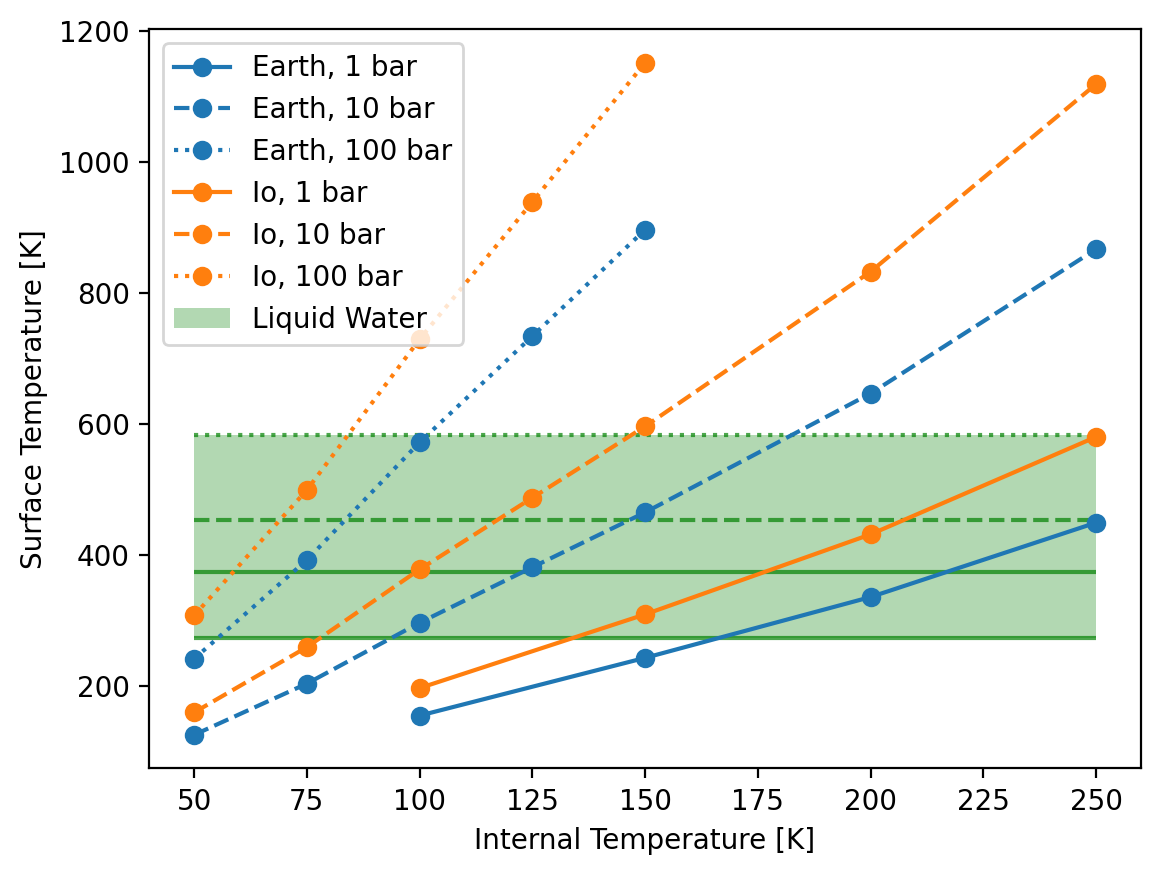

In [ ]:
fig, ax = plt.subplots()
linestyles = ['o-', 'o--', 'o:']
colors = ['tab:blue', 'tab:orange']

for i_planet, planet_name in enumerate(planets):
    for i_P0, p0_val in enumerate(P0s):
        mask = ~np.isnan(tsurfs[i_planet, i_P0, :])
        ax.plot(
            Tints[mask], 
            tsurfs[i_planet, i_P0, mask], 
            linestyles[i_P0], 
            color=colors[i_planet],
            label=f'{planet_name}, {p0_val/1e6:g} bar'
        )

xmin = 50
plt.hlines(T_freeze, xmin, Tints[-1], color='green', alpha=0.7, zorder=0)
plt.fill([xmin, xmin, Tints[-1], Tints[-1]], [T_boil[-1], T_freeze, T_freeze, T_boil[-1]], 'green', alpha=0.3, label='Liquid Water', zorder=-5)
for i_P0 in range(len(P0s)):
    plt.hlines(T_boil[i_P0], xmin, Tints[-1], color='green', linestyle=linestyles[i_P0][1:], alpha=0.7, zorder=0)

ax.set_xlabel('Internal Temperature [K]')
ax.set_ylabel('Surface Temperature [K]')
ax.legend()
plt.show()

In [22]:
# Calculate internal temperature where surface temperature is equal to freezing point

loop_overs = planets

Tints_freeze = np.zeros((len(loop_overs), len(P0s)))

for i_P0 in range(len(P0s)):
    for i, loop_over in enumerate(loop_overs):
        if np.isnan(tsurfs[i,i_P0,:]).all():
            continue
        mask = np.isnan(tsurfs[i,i_P0,:])
        Tsurf = tsurfs[i,i_P0,~mask]
        Tint = Tints[~mask]

        # interpolate Tsurf to find Tint
        f = interp1d(Tsurf, Tint, bounds_error=False, fill_value='extrapolate')
        Tint_freeze = f(T_freeze)

        Tints_freeze[i,i_P0] = Tint_freeze

        print(f'{loop_over} P0={P0s[i_P0]*1e-6:.0f} bar: Tint_freeze = {Tint_freeze:.2f} K')

print(np.average(Tints_freeze[1,:]/Tints_freeze[0,:]))

print((1821 / 6371)**(3/4))


Earth P0=1 bar: Tint_freeze = 166.57 K
Io P0=1 bar: Tint_freeze = 134.18 K
Earth P0=10 bar: Tint_freeze = 93.86 K
Io P0=10 bar: Tint_freeze = 78.03 K
Earth P0=100 bar: Tint_freeze = 55.32 K
Io P0=100 bar: Tint_freeze = 45.57 K
0.8202062764967631
0.3909099776119995


In [23]:
# connect Tsurf to time evolution

# read in T_eff data from data/T_eff.dat (format: index, time, T_eff)
T_eff = np.loadtxt('../../HELIOS/analyze/data/T_eff.dat')
print(T_eff.shape)

n_time = int(1000/10 + 1)

T_eff = T_eff.reshape((-1,n_time,3))
print(T_eff.shape)
print(T_eff[2,:,0].astype(int))

(701445, 3)
(6945, 101, 3)
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


Time t = 300.95966959047416
> inf K: 0 out of 6945


Text(0.5, 1.0, 'T_eff at t=301 Myr')

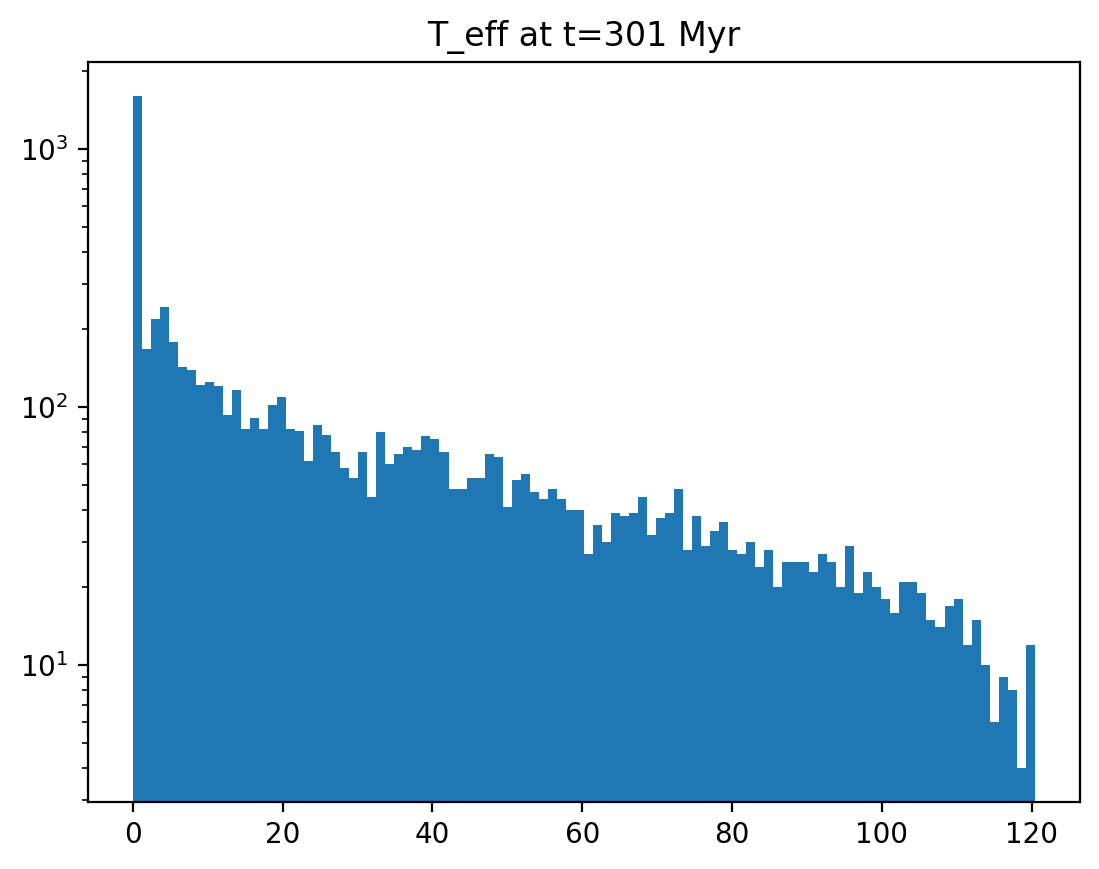

In [24]:
time = 300 # Myr
i_time = np.argmin(np.abs(T_eff[0,:,1] - time))
print('Time t =', T_eff[0,i_time,1])

plot_T_eff = T_eff[:,i_time,2]

T_max = np.inf
T_eff_mask = plot_T_eff < T_max
print(f'> {T_max} K:', np.sum(~T_eff_mask), 'out of', len(plot_T_eff))
plot_T_eff = plot_T_eff[T_eff_mask]


plt.hist(plot_T_eff, bins=100, log=True)
plt.title(f'T_eff at t={T_eff[0,i_time,1]:.0f} Myr')

In [25]:
# calculate time spent in the habitable zone

t_minmax = np.zeros((len(loop_overs), len(P0s), T_eff.shape[0], 2))

for i in range(len(loop_overs)):
    for i_p, P in enumerate(P0s):
        habitable = np.zeros(T_eff.shape[0], dtype=bool)
        for i_t in range(n_time):
            T_eff_i = T_eff[:, i_t, 2]
            T_surf_i = np.interp(T_eff_i, Tints, tsurfs[i, i_p, :])

            mask = np.logical_and(T_surf_i >= T_freeze, T_surf_i <= T_boil[i_p])
            if np.any(mask):
                mask = np.logical_and(~habitable, mask)
                t_minmax[i, i_p, mask, 0] = T_eff[mask, i_t, 1]
                habitable[mask] = True
            
            mask = np.logical_and(habitable, ~mask)
            if np.any(mask):
                t_minmax[i, i_p, mask, 1] = T_eff[mask, i_t, 1]
                habitable[mask] = False


print(t_minmax.min(), t_minmax.max())

time_habitable = t_minmax[:, :, :, 1] - t_minmax[:, :, :, 0]
print(time_habitable[time_habitable!=0.0].min(), time_habitable.max())
print(time_habitable.shape)


0.0 10000.268264840204
-880.7459865320452 880.7459865320452
(2, 3, 6945)


Habitability for an Earth atmosphere
for P0 = 1 bar: 1315 out of 6945 or 18.9% reach the HZ
min: 0.09659129955659385 max: 8.848640237465844
for P0 = 10 bar: 2078 out of 6945 or 29.9% reach the HZ
min: 0.09659129955659385 max: 66.64122044021417
for P0 = 100 bar: 2957 out of 6945 or 42.6% reach the HZ
min: 0.09659129955659385 max: 421.24443672344023


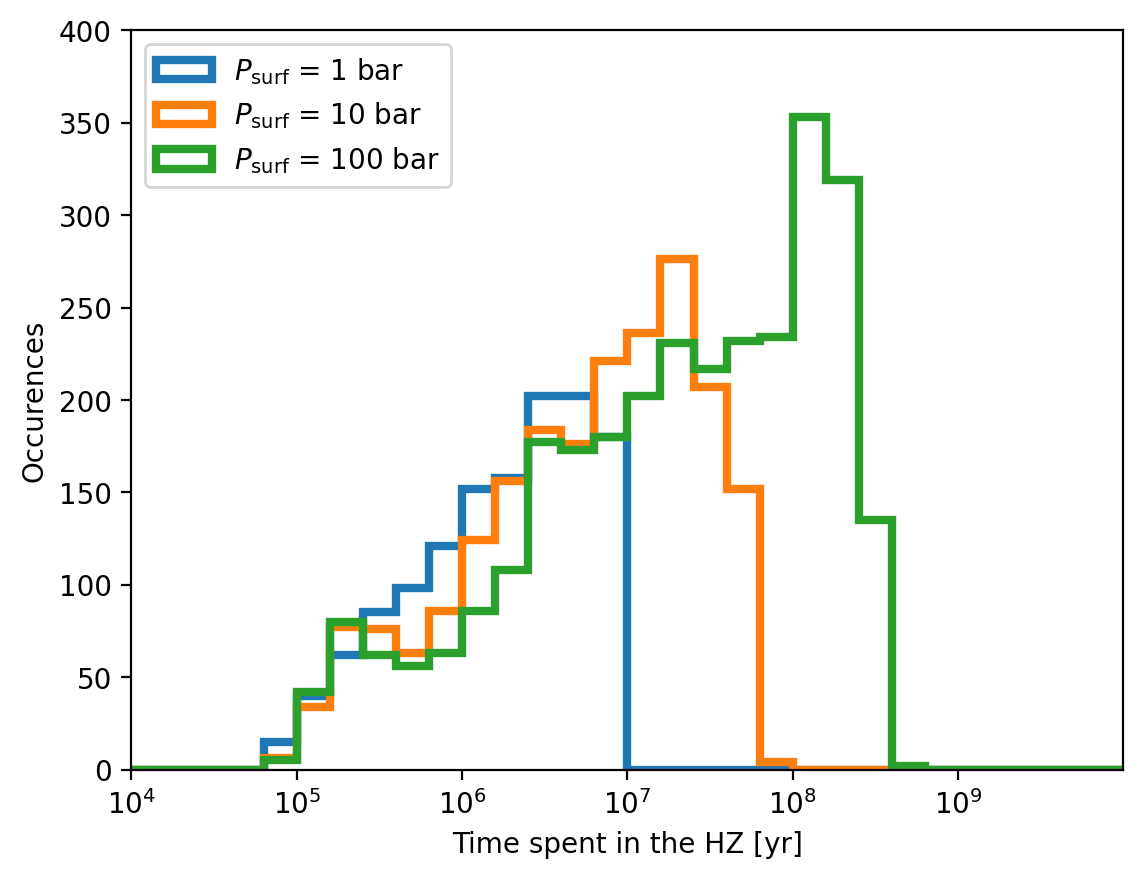

In [26]:
i_loop = 0

hist_min = 4 - 6
hist_max = 10 - 6

print(f'Habitability for an {loop_overs[i_loop]} atmosphere')
for i_p, P in enumerate(P0s):
    mask = time_habitable[i_loop, i_p, :] > 0
    print(f'for P0 = {P*1e-6:g} bar:', np.sum(mask), 'out of', len(mask), f'or {np.sum(mask)/len(mask)*100:.1f}% reach the HZ')
    print('min:', time_habitable[i_loop, i_p, mask].min(), 'max:', time_habitable[i_loop, i_p, mask].max())
    plt.hist(np.log10(time_habitable[i_loop, i_p, mask]), bins=np.linspace(hist_min, hist_max, 31), label=r'$P_\mathrm{surf}$ = ' + f'{P*1e-6:g} bar', histtype='step', linewidth=3)

plt.xticks(np.arange(hist_min, hist_max, 1), [r'$10^{i}$'.format(i=i) for i in np.arange(hist_min, hist_max, 1)+6])
plt.xlim(hist_min, hist_max)
plt.ylim(0,400)

#.title(f'{i_param.replace('plus', '+').replace('to', '/')} = {loop_overs[i_loop]:.0e} atmosphere')
#plt.title(f'{loop_overs[i_loop][1:]} atmosphere')
plt.xlabel('Time spent in the HZ [yr]')
plt.ylabel('Occurences')

plt.legend()

if False:
    plt.title('')
    set_white(plt.gca())
    increase_size(plt.gca(), linewidth=2, fontsize=15, legendloc='upper left')

    plt.tight_layout()

    #plt.ylabel('')
    #plt.gca().set_yticklabels([])

    plt.savefig(f'images/ASES5/TimeInHZ_CplusO={CplusOs[i_CplusO]:.0e}_CtoO={CtoOs[i_CtoO]:g}{adds[i_loop]}.svg', transparent=True)

In [27]:
# get index with the maximum time spent in the HZ
max_index = np.argmax(time_habitable[i_loop, :, :], axis=-1)
print(max_index, time_habitable.shape)
for i, max_ind in enumerate(max_index):
    print(f'Maximum time spent in the HZ: {np.max(time_habitable[i_loop, :, max_ind])} yr for P0 = {P0s[i]*1e-6:.0f} bar')
    print(f'Index: {max_ind}, T_eff_init: {T_eff[max_ind, 0, 2]:.0f} K')

[3030  378 2008] (2, 3, 6945)
Maximum time spent in the HZ: 31.873257211693954 yr for P0 = 1 bar
Index: 3030, T_eff_init: 132 K
Maximum time spent in the HZ: 139.3347480072241 yr for P0 = 10 bar
Index: 378, T_eff_init: 86 K
Maximum time spent in the HZ: 421.24443672344023 yr for P0 = 100 bar
Index: 2008, T_eff_init: 53 K
